Preparing the dataset and folders mapping

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Data Simulation

In [2]:
import pandas as pd
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

# Simulate monthly dates from Jan 2018 to Dec 2022
dates = pd.date_range(start='2018-01-01', end='2022-12-01', freq='MS')

# Simulate base trends
food_trend = np.linspace(100, 130, len(dates))  # gradually rising food price index
fuel_trend = np.linspace(90, 120, len(dates))   # gradually rising fuel price index

# Add seasonality
seasonal_effect = 5 * np.sin(np.linspace(0, 12 * np.pi, len(dates)))

# Final indices with noise
food_prices = food_trend + seasonal_effect + np.random.normal(0, 2, len(dates))
fuel_prices = fuel_trend + seasonal_effect + np.random.normal(0, 3, len(dates))

# Inflation rate simulated as function of prices + random noise
inflation_rate = (
    0.02 * food_prices +
    0.015 * fuel_prices +
    np.random.normal(0, 0.5, len(dates))
)
inflation_rate = np.clip(inflation_rate, 1.0, 8.0)  # realistic bounds

# Create dataframes
df_prices = pd.DataFrame({
    'Date': dates,
    'Food_Price_Index': food_prices.round(2),
    'Fuel_Price_Index': fuel_prices.round(2)
})

df_inflation = pd.DataFrame({
    'Date': dates,
    'Inflation_Rate': inflation_rate.round(2)
})

# Save to Google Drive
data_path = '/content/drive/MyDrive/Inflation_Shock_Modeling/data'
df_prices.to_csv(f'{data_path}/food_fuel_prices.csv', index=False)
df_inflation.to_csv(f'{data_path}/macro_inflation.csv', index=False)

print("Data simulation complete. Files saved to /data folder.")


Data simulation complete. Files saved to /data folder.


Exploratory Data Analysis (EDA)

Sample Data:


,Date,Food_Price_Index,Fuel_Price_Index,Inflation_Rate
0,2018-01-01,100.99,88.56,3.74
1,2018-02-01,103.21,92.93,3.00
2,2018-03-01,107.10,92.49,4.23
3,2018-04-01,109.27,92.64,2.87
4,2018-05-01,104.33,97.24,3.84



 Null Check:
Date                0
Food_Price_Index    0
Fuel_Price_Index    0
Inflation_Rate      0
dtype: int64


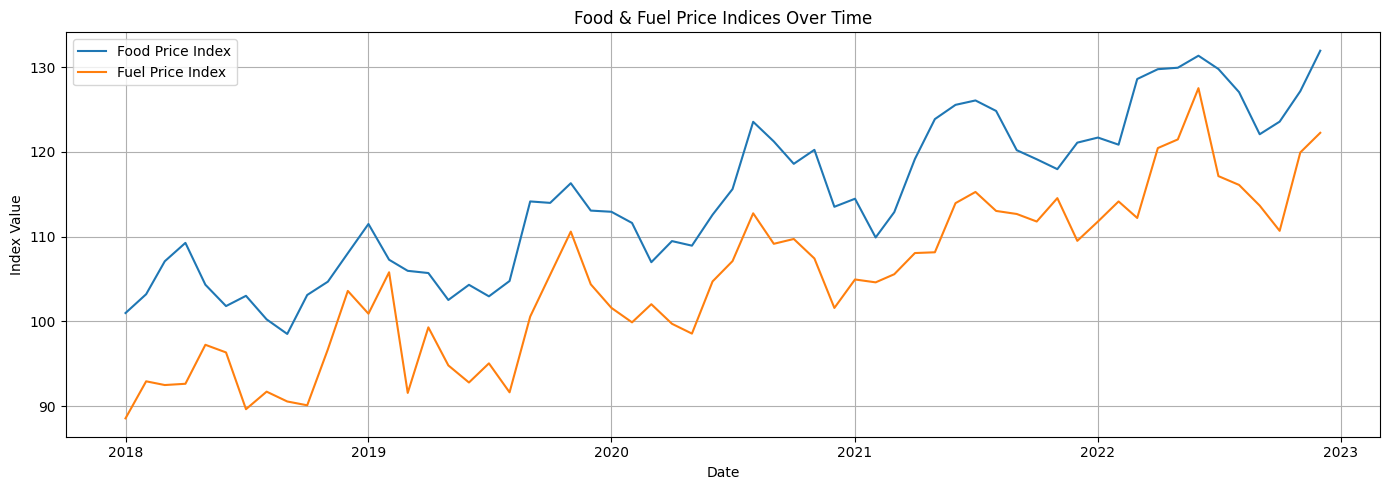

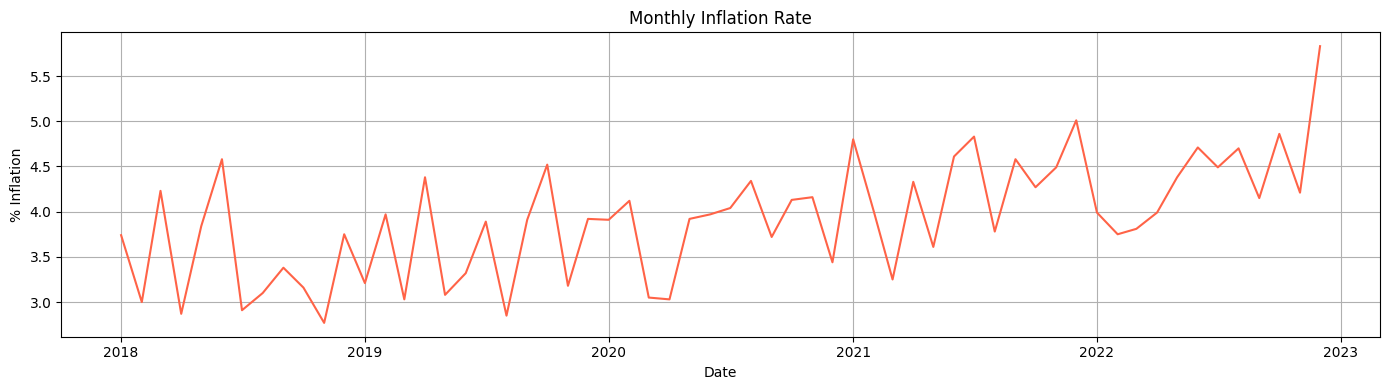

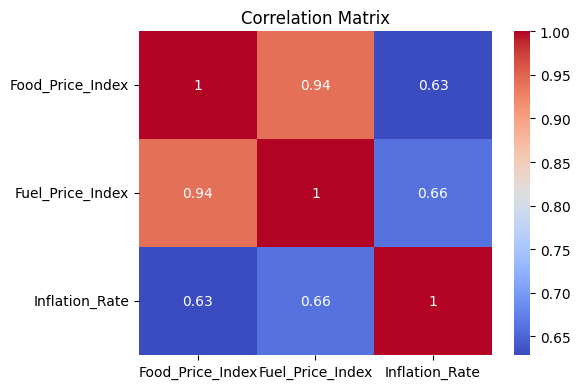

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data_path = '/content/drive/MyDrive/Inflation_Shock_Modeling/data'
output_path = '/content/drive/MyDrive/Inflation_Shock_Modeling/output'

df_prices = pd.read_csv(f'{data_path}/food_fuel_prices.csv', parse_dates=['Date'])
df_inflation = pd.read_csv(f'{data_path}/macro_inflation.csv', parse_dates=['Date'])

# Merge for combined analysis
df_merged = pd.merge(df_prices, df_inflation, on='Date')

# Display first few rows
print("Sample Data:")
display(df_merged.head())

# Check for nulls
print("\n Null Check:")
print(df_merged.isnull().sum())

# Plot food and fuel price trends
plt.figure(figsize=(14, 5))
plt.plot(df_merged['Date'], df_merged['Food_Price_Index'], label='Food Price Index')
plt.plot(df_merged['Date'], df_merged['Fuel_Price_Index'], label='Fuel Price Index')
plt.title('Food & Fuel Price Indices Over Time')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{output_path}/food_fuel_trends.png')  # ← Save plot
plt.show()

# Plot inflation trend
plt.figure(figsize=(14, 4))
plt.plot(df_merged['Date'], df_merged['Inflation_Rate'], color='tomato', label='Inflation Rate')
plt.title('Monthly Inflation Rate')
plt.xlabel('Date')
plt.ylabel('% Inflation')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{output_path}/inflation_trend.png')  # ← Save plot
plt.show()

# Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df_merged[['Food_Price_Index', 'Fuel_Price_Index', 'Inflation_Rate']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig(f'{output_path}/correlation_matrix.png')  # ← Save plot
plt.show()


ARIMA Forecasting of Inflation Rate

In [7]:
!pip install statsmodels --quiet


ADF statistic: -0.18325807177212278
p-value: 0.9404880102072108
Fitting ARIMA(1,1,1)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         Inflation_Rate   No. Observations:                   60
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -48.659
Date:                Fri, 18 Jul 2025   AIC                            103.318
Time:                        08:07:46   BIC                            109.551
Sample:                    01-01-2018   HQIC                           105.751
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2577      0.153     -1.685      0.092      -0.557       0.042
ma.L1         -0.7902      0.117     -6.730      0.000      -1.020      -0.560
sigma2         0.2975      0.068      4.388      0.0

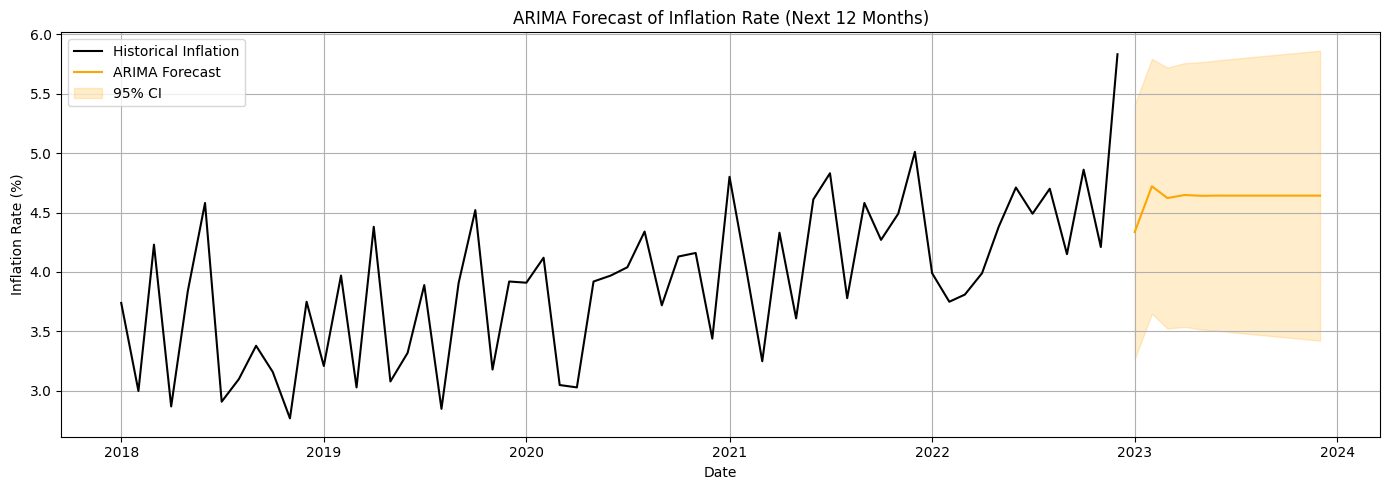

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from datetime import timedelta

# Load your merged dataframe
data_path = '/content/drive/MyDrive/Inflation_Shock_Modeling/data'
output_path = '/content/drive/MyDrive/Inflation_Shock_Modeling/output'
df_merged = pd.merge(
    pd.read_csv(f'{data_path}/food_fuel_prices.csv', parse_dates=['Date']),
    pd.read_csv(f'{data_path}/macro_inflation.csv', parse_dates=['Date']),
    on='Date'
)

# Prepare time series
ts = df_merged.set_index('Date')['Inflation_Rate']

# Check stationarity
result = adfuller(ts)
print("ADF statistic:", result[0])
print("p-value:", result[1])

# Automatically pick order based on ADF result
# If non-stationary, include one difference (d=1)
d = 1 if result[1] > 0.05 else 0
p = 1
q = 1

print(f"Fitting ARIMA({p},{d},{q})")

model = ARIMA(ts, order=(p, d, q))
fitted = model.fit()
print(fitted.summary())

# Forecast 12 months ahead
n_periods = 12
last_date = ts.index[-1]
forecast_res = fitted.get_forecast(steps=n_periods)
forecast = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()

# Create DataFrame and save
forecast_dates = pd.date_range(last_date + timedelta(days=1), periods=n_periods, freq='MS')
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast_Inflation_Rate': forecast.values
})
forecast_df.to_csv(f'{output_path}/forecast_arima.csv', index=False)

# Plot actual vs forecast
plt.figure(figsize=(14, 5))
plt.plot(ts.index, ts, label='Historical Inflation', color='black')
plt.plot(forecast_dates, forecast, label='ARIMA Forecast', color='orange')
plt.fill_between(forecast_dates,
                 conf_int['lower Inflation_Rate'],
                 conf_int['upper Inflation_Rate'],
                 color='orange', alpha=0.2, label='95% CI')
plt.title('ARIMA Forecast of Inflation Rate (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{output_path}/arima_inflation_forecast.png')
plt.show()


Price Elasticity Mapping

                            OLS Regression Results                            
Dep. Variable:         Inflation_Rate   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     4.690
Date:                Fri, 18 Jul 2025   Prob (F-statistic):             0.0131
Time:                        08:09:26   Log-Likelihood:                -258.57
No. Observations:                  59   AIC:                             523.1
Df Residuals:                      56   BIC:                             529.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.7104      2.636  

/tmp/ipython-input-9-3491484110.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=elasticities.index, y=elasticities.values, palette='Blues_d')


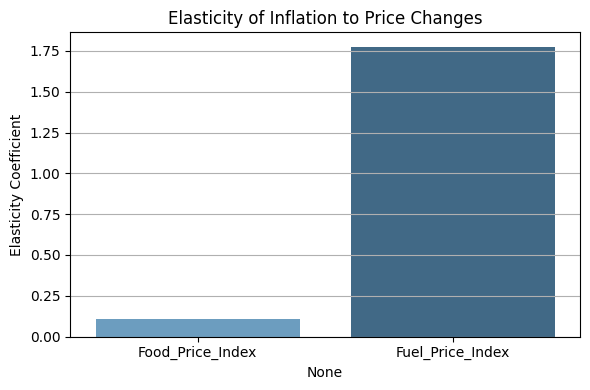

Elasticity mapping complete and saved.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Load data
data_path = '/content/drive/MyDrive/Inflation_Shock_Modeling/data'
output_path = '/content/drive/MyDrive/Inflation_Shock_Modeling/output'

df_prices = pd.read_csv(f'{data_path}/food_fuel_prices.csv', parse_dates=['Date'])
df_inflation = pd.read_csv(f'{data_path}/macro_inflation.csv', parse_dates=['Date'])
df = pd.merge(df_prices, df_inflation, on='Date')

# Compute percent change (Δ%)
df_pct = df.copy()
df_pct[['Food_Price_Index', 'Fuel_Price_Index', 'Inflation_Rate']] = df_pct[['Food_Price_Index', 'Fuel_Price_Index', 'Inflation_Rate']].pct_change() * 100
df_pct.dropna(inplace=True)

# Regression: Δ Inflation ~ Δ Food + Δ Fuel
X = df_pct[['Food_Price_Index', 'Fuel_Price_Index']]
y = df_pct['Inflation_Rate']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

# Extract elasticity coefficients
elasticities = model.params.drop('const')

# Plot elasticities
plt.figure(figsize=(6, 4))
sns.barplot(x=elasticities.index, y=elasticities.values, palette='Blues_d')
plt.title("Elasticity of Inflation to Price Changes")
plt.ylabel("Elasticity Coefficient")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig(f'{output_path}/price_elasticity_plot.png')
plt.show()

# Save coefficients
elasticities.to_frame(name='Elasticity_Coefficient').to_csv(f'{output_path}/price_elasticity_coefficients.csv')

print("Elasticity mapping complete and saved.")


Volatility Mapping (Inflation Shock Intensity)

Objective:

Identify shock periods by mapping how volatile inflation is over time.
We'll use rolling standard deviation (30-day window) as a proxy for volatility.

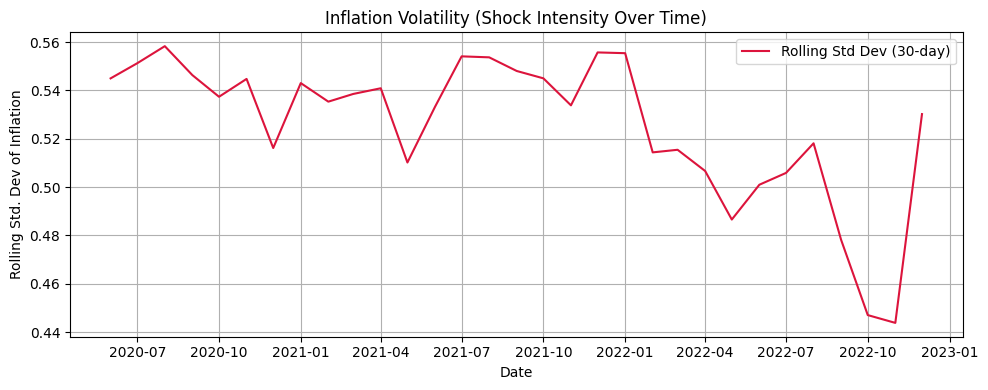

Volatility mapping complete and saved.


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load inflation data
data_path = '/content/drive/MyDrive/Inflation_Shock_Modeling/data'
output_path = '/content/drive/MyDrive/Inflation_Shock_Modeling/output'

df_inflation = pd.read_csv(f'{data_path}/macro_inflation.csv', parse_dates=['Date'])
df_inflation.sort_values('Date', inplace=True)

# Compute 30-day rolling volatility
df_inflation['Inflation_Rolling_Std'] = df_inflation['Inflation_Rate'].rolling(window=30).std()

# Plot volatility
plt.figure(figsize=(10, 4))
sns.lineplot(x='Date', y='Inflation_Rolling_Std', data=df_inflation, label='Rolling Std Dev (30-day)', color='crimson')
plt.title("Inflation Volatility (Shock Intensity Over Time)")
plt.xlabel("Date")
plt.ylabel("Rolling Std. Dev of Inflation")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f'{output_path}/inflation_volatility_plot.png')
plt.show()

# Save data
df_inflation[['Date', 'Inflation_Rolling_Std']].dropna().to_csv(f'{output_path}/inflation_volatility_series.csv', index=False)

print("Volatility mapping complete and saved.")


**Project Summary: Inflation Shock Modeling**

Objective:
To model and interpret the impact of food and fuel price shocks on overall inflation rates using lightweight econometric techniques. The project aims to simulate macro-level inflation responses and assess price elasticity and volatility of inflation in response to sectoral drivers.

**Key Techniques Used:**

ARIMA Time Series Forecasting

Price Elasticity Modeling (OLS Regression)

Volatility Mapping (Rolling Std. Dev and Signal Plots)

**Highlights from Elasticity Analysis:**

Fuel Price Index has a strong and statistically significant effect on inflation (coef = 1.7753, p = 0.006), indicating high elasticity.

Food Price Index showed minimal impact (coef = 0.1080, p = 0.905), implying near inelasticity over the observed period.

This suggests that fuel-driven inflation shocks dominate food-driven ones in short-term macroeconomic scenarios.

**Insights:**

Inflation exhibits higher volatility in fuel-sensitive periods, as reflected in rolling std deviation plots.

Policymakers should prioritize fuel price controls or buffers when addressing inflation volatility, especially in energy-importing economies.

**Tools:**
pandas, matplotlib, statsmodels, seaborn.